# Position Predictor (In Progress)

`Given the position of 1,3,5 players + ball have the model try and predict the position of the other player.`

The intent of this notebook is to document model selection for this position prediction task.

In [1]:
import carball
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import importlib
import itertools
import random
import xgboost as xgb

In [2]:
# CONFIGS
POSITION_COLUMNS = ['pos_x', 'pos_y', 'pos_z']
NCOLS = len(POSITION_COLUMNS)
RANDOM_SEED = 42
TEST_RATIO = 0.2
CACHE_PATH = "./.replay_cache"

In [3]:
random.seed(RANDOM_SEED)

## Data Exploration

Before doing anything, I need to just get a grip on what the data is and what can be done with it.

In [4]:
import data
importlib.reload(data)
data_manager = data.FileCachedCalculated()

Caching replays at: /home/axelmagn/.replays_cache


In [5]:
replays = data_manager.get_replay_list(num=10)

In [6]:
replays

['D4DE3A894229D5B8A5D0AE9091D3CA6C',
 '4DC852DA4D28F5D9047C509CA03412C8',
 'EF578C404F791CE044EFDEB0036DA5EA',
 'B828B7FD472EE7A19E9A9C8ECB7CA14B',
 'A21C39DD402315E9831EC58C7A331F64',
 '1C1AA99611E7A6E035C32F9551CD5D38',
 '7901299C11E7D3B2E06E8CB0DF9F6172',
 '997C8F1E11E7F7D384BBD0BC1A6F09FC',
 'F15A0B1211E814E30254D78BDDA89CDC',
 'B61A9AA211E829665CEB87A590E3C53A']

In [7]:
df0 = data_manager.get_pandas(replays[1])

In [8]:
df0.head()

Hunter746                                                               \
          pos_x   pos_y pos_z     rot_x     rot_y    rot_z vel_x vel_y vel_z   
index                                                                          
0       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
1       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
2       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
3       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   
4       -2048.0 -2560.0  18.0 -6.272256 -2.356183 -0.00278   0.0   0.0  81.0   

                 ...      xcuttington21                                  \
      ang_vel_x  ... double_jump_active dodge_active ping boost_collect   
index            ...                                                      
0           0.0  ...              False        False  NaN           NaN   
1           0.0  ...              False        False  NaN           NaN   
2           0.0  ...              False        False  NaN           NaN   
3           0.0  ...              False        False  NaN           NaN   
4           0.0  ...              False        False  NaN           NaN   

            game                                                           \
            time     delta seconds_remaining replicated_seconds_remaining   
index                                                                       
0      19.284970  0.004000             300.0                          NaN   
1      19.321173  0.036207             300.0                          NaN   
2      19.357170  0.036002             300.0                          NaN   
3      19.393167  0.036002             300.0                          NaN   
4      19.429302  0.036138             300.0                          NaN   

                                     
      ball_has_been_hit goal_number  
index                                
0                  None         NaN  
1                  None         NaN  
2                  None         NaN  
3                  None         NaN  
4                  None         NaN  

[5 rows x 154 columns]

In [9]:
df0.columns

MultiIndex(levels=[['Hunter746', 'Hunters Coach', 'ball', 'game', 'jjgamer345', 'madkillerDC', 'oeskrew187', 'xcuttington21'], ['ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'ball_cam', 'ball_has_been_hit', 'boost', 'boost_active', 'boost_collect', 'delta', 'dodge_active', 'double_jump_active', 'goal_number', 'handbrake', 'hit_team_no', 'jump_active', 'ping', 'pos_x', 'pos_y', 'pos_z', 'replicated_seconds_remaining', 'rot_x', 'rot_y', 'rot_z', 'seconds_remaining', 'steer', 'throttle', 'time', 'vel_x', 'vel_y', 'vel_z']],
           codes=[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 7, 3, 3, 3, 3, 3, 3]

In [10]:
df0['ball'].tail()

,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,ang_vel_y,ang_vel_z,hit_team_no
index,,,,,,,,,,,,,
11145,3304,1088,157,-5.481956,-1.391006,-1.539565,-4687.0,-13167.0,-6975.0,-4736.0,-1810.0,2918.0,0.0
11146,3281,1024,123,-5.286370,-1.302130,-1.596035,-2668.0,-16516.0,-2480.0,1694.0,-53.0,1439.0,0.0
11147,3272,969,115,-5.340156,-1.279407,-1.626716,-2665.0,-16500.0,-2694.0,1694.0,-53.0,1439.0,0.0
11148,3263,914,105,-5.393559,-1.255630,-1.657204,-2662.0,-16483.0,-2908.0,1694.0,-53.0,1439.0,0.0
11149,3254,859,95,-5.446386,-1.230799,-1.687500,-2660.0,-16466.0,-3122.0,1694.0,-53.0,1439.0,0.0


In [11]:
df0['game'].head()

,time,delta,seconds_remaining,replicated_seconds_remaining,ball_has_been_hit,goal_number
index,,,,,,
0,19.284970,0.004000,300.0,NaN,None,NaN
1,19.321173,0.036207,300.0,NaN,None,NaN
2,19.357170,0.036002,300.0,NaN,None,NaN
3,19.393167,0.036002,300.0,NaN,None,NaN
4,19.429302,0.036138,300.0,NaN,None,NaN


In [12]:
df0['Hunter746'].head()

,pos_x,pos_y,pos_z,rot_x,rot_y,rot_z,vel_x,vel_y,vel_z,ang_vel_x,...,steer,handbrake,ball_cam,jump_active,double_jump_active,boost,boost_active,dodge_active,ping,boost_collect
index,,,,,,,,,,,,,,,,,,,,,
0,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
1,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
2,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
3,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN
4,-2048.0,-2560.0,18.0,-6.272256,-2.356183,-0.00278,0.0,0.0,81.0,0.0,...,NaN,None,True,False,False,84.0,False,False,6,NaN


In [13]:
df0['Hunter746'].columns

Index(['pos_x', 'pos_y', 'pos_z', 'rot_x', 'rot_y', 'rot_z', 'vel_x', 'vel_y',
       'vel_z', 'ang_vel_x', 'ang_vel_y', 'ang_vel_z', 'throttle', 'steer',
       'handbrake', 'ball_cam', 'jump_active', 'double_jump_active', 'boost',
       'boost_active', 'dodge_active', 'ping', 'boost_collect'],
      dtype='object')

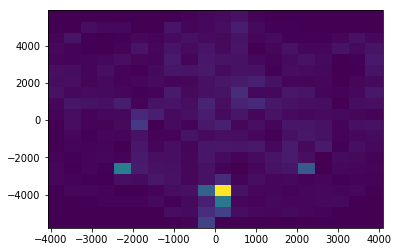

In [14]:
p0_xy = df0['Hunter746'][["pos_x", "pos_y"]].dropna()
x = p0_xy['pos_x']
y = p0_xy['pos_y']
plt.hist2d(x,y, bins=20)
plt.show()

In [15]:
proto0 = data_manager.get_proto(replays[1])

In [16]:
# (verbose)
# proto0.players[0]

## Data Retrieval (TODO)

This stage retrieves replays from the internet, and caches them locally.


### Train / Validation / Test Split (TODO)

Data partitioning should be done on a per-replay basis, so that there are no chances for the model to memorize similar frames from the same replay.

In [17]:
class Replay(object):
    def __init__(self, df, proto):
        self.df = df
        self.proto = proto

def get_replay(replay_id, manager):
    df = manager.get_pandas(replay_id)
    proto = manager.get_proto(replay_id)
    return Replay(df, proto)

In [18]:
# for now, we will just do a manual split of the first 10 replays
replays = data_manager.get_replay_list(num=10)

In [19]:
train_replays = replays[:6]
validate_replays = replays[6:8]
test_replays = replays[8:]

## Preprocessing

This stage takes replay dataframes and protobufs and prepares them as a numpy matrix suitable for model ingestion and analysis. There are 2 possible schemas I want to explore for state representation. 


### Schema: analog positions (DONE)

Records shall be represented as position vectors as shown below

```
<ball> <t0_p0> <t0_p1> <t0_p2> <t1_p0> <t1_p1> <t1_p2>
foreach: <pos_x> <pos_y> <pos_z>
```

### Schema: rasterized positions (TODO)

Records shall be represented as 3-channel rasterized images, with a channel each for ball, team_0, and team_1.   This can be generated from the condensed positions.

### Filtering (TODO)

Starting positions are likely to be over-represented in this dataset.  It may be useful to filter out all frames before a ball has been hit.

### Reordering (TODO)

The data could then be expanded to capture the symmetries of team and player reordering.  Player ordering in the condensed schema is arbitrary, and each record could generate `3! * 3! = 36` permutations. Team ordering is not arbitrary, but teams could be swapped by negating `pos_y` values.  This would increase the total available permutations to `36 * 2 = 72`.  There is also x-axis symmetry, so by negating X values we get another mirror, bringing it to `72 * 2 = 144` permutations.

### Distortion (TODO)

Optionally, it would be possible to slightly randomize positions, in order to help generalize.


### Dropout (TODO)

The original plan was to omit one player, and make the predictor guess it. If we are already have generated all reorderings, it should be sufficient to simply omit the final player.  However, I would also like to explore the possibility of a GAN or Autoencoder where one position within a valid record is fabricated, and the predictor must reconstruct the valid position from the invalid one.

In [20]:
# Analog Positions

def load_analog(replay_id, manager):
    replay = get_replay(replay_id, manager)
    return analog_positions(replay)

def analog_positions(replay):
    proto = replay.proto
    dataframe = replay.df
    ball_posn = get_named_posn(dataframe, 'ball')
    ball_posn = add_col_prefix(ball_posn, "ball_")
    t0_posns = []
    t1_posns = []
    for player in proto.players:
        posn = get_named_posn(dataframe, player.name)
        if player.is_orange == 0:
            t0_posns.append(posn)
        else:
            t1_posns.append(posn)
    for i, posn in enumerate(t0_posns):
        t0_posns[i] = add_col_prefix(posn, 't0_p{}_'.format(i))
    for i, posn in enumerate(t1_posns):
        t1_posns[i] = add_col_prefix(posn, 't1_p{}_'.format(i))
    positions = [ball_posn] + t0_posns + t1_posns
    return pd.concat(positions, axis=1).dropna()

def get_named_posn(dataframe, name):
    return dataframe[name][POSITION_COLUMNS]

def get_named_player(proto, player_name):
    for player in proto.players:
        if player.name == player_name:
            return player
    raise ValueError("Could not find player: " + player_name)
    
def add_col_prefix(dataframe, prefix):
    return dataframe.rename(lambda col: prefix + col, axis='columns')

In [21]:
train_aps = pd.concat((load_analog(replay_name, data_manager) for replay_name in train_replays), axis=0)

In [22]:
validate_aps = pd.concat((load_analog(replay_name, data_manager) for replay_name in validate_replays), axis=0)

In [23]:
# Split features and targets
def get_analog_features(analog_positions_dataframe):
    return analog_positions_dataframe.values[:,:-NCOLS]

def get_analog_targets(analog_positions_dataframe):
    return analog_positions_dataframe.values[:,-NCOLS:]

# TODO: split train, validation, and test sets based on multiple replays

In [24]:
train_features = get_analog_features(train_aps)
train_targets = get_analog_targets(train_aps)
validate_features = get_analog_features(validate_aps)
validate_targets = get_analog_targets(validate_aps)

## Model Selection

This stage evaluates different models on the training data.  Below is a list of model hypotheses that should be considered.

### Models

#### Random (Null Hypothesis) (TODO)

Our null hypothesis is that our predictor does not add any information to the problem, and we might as well be guessing a position from a distribution.  There are a number of possible distributions we could draw from:

1. Uniform
2. Gaussian
3. KDE / Histogram of training values

#### XGBoost (Baseline) (In Progress)

XGBoost performs well at many complex regression problems, and is easy to apply using a library.  It will serve as the baseline against which more sophisticated model hypotheses can be compared.

#### Clustering / KNN (Baseline) (TODO)

Another simple solution would be to retrieve similar memorized positions.

#### Deep Neural Networks (TODO)

After baselines have been measured, more sophisticated models such as convolutional neural networks can be considered.

### Selection Criteria

As important as the models is our criteria for evaluating them.  Since this problem does not easily map to a real-world loss function, this can be somewhat arbitrary, and may depend on the output schema.

#### RMSE (Single Output Schema)

If the model is outputting a single guess, it makes sense to use a simple RMSE to evaluate model performance.

#### Probability Weighted RMSE (Distribution Output Schema)

If the model outputs a probability distribution across multiple possible positions, I think it makes sense to add up the RMSE of those positions, multiplied by their predicted probability weight.



In [25]:
# For now, just train and test an untuned xgboost model
param = { 'objective':'reg:squarederror' }
num_round = 100
dtrain = xgb.DMatrix(train_features, label=train_targets)
dvalid = xgb.DMatrix(validate_features, label=validate_targets)
evallist = [(dvalid, 'eval'), (dtrain, 'train')]
evals_result = {}
model = xgb.train(param, dtrain, num_round, evallist, evals_result=evals_result, verbose_eval=num_round/5)

/home/axelmagn/workspace/saltieRL/ReplayModels/venv/lib/python3.7/site-packages/xgboost/core.py:613: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn("Use subset (sliced data) of np.ndarray is not recommended " +


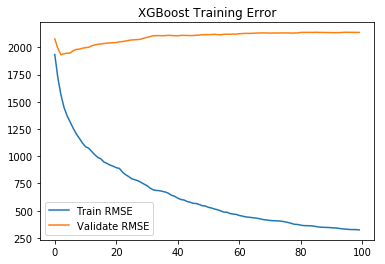

In [26]:
plt_X = range(num_round)
plt.plot(plt_X, evals_result['train']['rmse'], label='Train RMSE')
plt.plot(plt_X, evals_result['eval']['rmse'], label='Validate RMSE')
plt.title("XGBoost Training Error")
plt.legend()
plt.show()